<a href="https://colab.research.google.com/github/bsse1009/Dbms2/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings

In [165]:
data = pd.read_csv("/content/fetal_health.csv")
print(data.shape)
data.head()

(2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


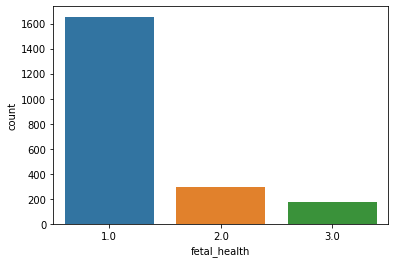

In [166]:
sns.countplot(data['fetal_health'])

In [167]:
data = data.drop(['histogram_min','histogram_median','histogram_mode'], axis=1)
data
# X=data.drop(['fetal_health'], axis=1)
# Y=data['fetal_health']
# bestfeatures = SelectKBest(score_func=f_classif, k='all')
# fit = bestfeatures.fit(X,Y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Feature','Score'] 
# selection=featureScores[featureScores['Score']>=200]#Selects features that scored more than 200
# selection=list(selection['Feature'])#Generates the features into a list
# selection.append('fetal_health')#Adding the Level string to be used to make new data frame
# new_fetal=data[selection] #New dataframe with selected features
# new_fetal.head()
# data = new_fetal

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mean,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,126.0,2.0,0.0,137.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,198.0,6.0,1.0,136.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,198.0,5.0,1.0,135.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,170.0,11.0,0.0,134.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,170.0,9.0,0.0,136.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,177.0,4.0,0.0,150.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,169.0,6.0,0.0,148.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,170.0,5.0,0.0,148.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,169.0,6.0,0.0,147.0,4.0,1.0,2.0


In [168]:
X = data.drop(['fetal_health'], axis=1)
y = data['fetal_health']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [169]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mean,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,164.025400,4.068203,0.323612,134.610536,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,17.944183,2.949386,0.706059,15.593596,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,122.000000,0.000000,0.000000,73.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,152.000000,2.000000,0.000000,125.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,162.000000,3.000000,0.000000,136.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,174.000000,6.000000,0.000000,145.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,238.000000,18.000000,10.000000,182.000000,269.000000,1.000000,3.000000


In [170]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=[3, 3, 3, 3, 3,2,2,3,3,3,3,3,3,3,2,3,3,3], encode='ordinal').fit(X)
# est = KBinsDiscretizer(n_bins=[3, 3, 3, 3, 3, 3], encode='ordinal').fit(X)
x = est.transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

In [171]:
class DicesionTree:

    def __init__(self, dataset):

        self.dataset = dataset



    @staticmethod

    def entropy(target_col):

        elements, counts = np.unique(target_col, return_counts=True)

        entropy = np.sum(

            [(-counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))])

        return entropy



    def info_gain(self, data, split_attribute_name, target_name="fetal_health"):

        total_entropy = self.entropy(data[target_name])

        vals, counts = np.unique(data[split_attribute_name], return_counts=True)

        weighted_entropy = np.sum(

            [(counts[i] / np.sum(counts)) * self.entropy(

                data.where(data[split_attribute_name] == vals[i]).dropna()[target_name])

             for i in range(len(vals))])



        information_gain = total_entropy - weighted_entropy

        return information_gain



    def train(self, data, original_data, features, target_attribute_name="fetal_health", parent_node_class=None):

        if len(np.unique(data[target_attribute_name])) <= 1:

            return np.unique(data[target_attribute_name])[0]



        elif len(data) == 0:

            return np.unique(original_data[target_attribute_name])[

                np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]



        elif len(features) == 0:

            return parent_node_class



        else:

            parent_node_class = np.unique(data[target_attribute_name])[

                np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]



            item_values = [self.info_gain(data, feature, target_attribute_name) for feature in

                           features]

            best_feature_index = np.argmax(item_values)

            # print(best_feature_index)

            best_feature = features[best_feature_index]



            tree = {best_feature: {}}

            features = [i for i in features if i != best_feature]



            for value in np.unique(data[best_feature]):

                value = value

                sub_data = data.where(data[best_feature] == value).dropna()

                subtree = self.train(sub_data, self.dataset, features, target_attribute_name, parent_node_class)

                tree[best_feature][value] = subtree



            return tree



    def predict(self, query, tree, default=1):

        # print(query)

        for key in list(query.keys()):

            if key in list(tree.keys()):

                try:

                    result = tree[key][query[key]]

                except:

                    return default

                result = tree[key][query[key]]

                if isinstance(result, dict):

                    return self.predict(query, result)

                else:

                    return result



    def test(self, data, tree):

        # print(data)

        queries = data.iloc[:, :-1].to_dict(orient="records")

        predicted = pd.DataFrame(columns=["predicted"])

        for i in range(len(data)):

            predicted.loc[i, "predicted"] = self.predict(queries[i], tree, 1)

        print('The prediction accuracy is: ', (np.sum(predicted["predicted"] == data["fetal_health"]) / len(data)) * 100, '%')





In [172]:
y = np.array(y)
y = y.reshape(2126,1)
print(x.shape)
print(y.shape)

(2126, 18)
(2126, 1)


In [173]:
data = np.concatenate([x, y], axis=1)

df = pd.DataFrame(data,columns=['baseline value',	'accelerations',	'fetal_movement',	'uterine_contractions',	'light_decelerations',	'severe_decelerations',	'prolongued_decelerations',	'abnormal_short_term_variability',	'mean_value_of_short_term_variability',	'percentage_of_time_with_abnormal_long_term_variability',	'mean_value_of_long_term_variability',	'histogram_width',	'histogram_max',	'histogram_number_of_peaks',	'histogram_number_of_zeroes',	'histogram_mean',	'histogram_variance',	'histogram_tendency',	'fetal_health'])
# df = pd.DataFrame(data,columns=['prolongued_decelerations',	'abnormal_short_term_variability',	'percentage_of_time_with_abnormal_long_term_variability',	'histogram_mode',	'histogram_mean',	'histogram_median',	'fetal_health'])
df.head

<bound method NDFrame.head of       baseline value  accelerations  ...  histogram_tendency  fetal_health
0                0.0            0.0  ...                 1.0           2.0
1                1.0            1.0  ...                 1.0           1.0
2                1.0            0.0  ...                 1.0           1.0
3                1.0            0.0  ...                 1.0           1.0
4                1.0            1.0  ...                 1.0           1.0
...              ...            ...  ...                 ...           ...
2121             2.0            0.0  ...                 1.0           2.0
2122             2.0            0.0  ...                 1.0           2.0
2123             2.0            0.0  ...                 1.0           2.0
2124             2.0            0.0  ...                 1.0           2.0
2125             2.0            0.0  ...                 1.0           1.0

[2126 rows x 19 columns]>

In [183]:
def train_test_split(dataset):

    training_data = dataset.iloc[:1680].reset_index(drop=True)

    testing_data = dataset.iloc[1680:].reset_index(drop=True)

    return training_data, testing_data

In [184]:
train, test_set = train_test_split(df)
print(train.shape)
print(test_set.shape)

(1680, 19)
(446, 19)


In [185]:
from pprint import pprint
dTree = DicesionTree(train)
tree = dTree.train(train, train, train.columns[:-1])
pprint(tree)
dTree.test(test_set, tree)

{'abnormal_short_term_variability': {0.0: {'histogram_width': {0.0: 1.0,
                                                               1.0: {'accelerations': {0.0: {'histogram_max': {0.0: {'mean_value_of_long_term_variability': {0.0: {'histogram_number_of_peaks': {0.0: 1.0,
                                                                                                                                                                                                 1.0: {'histogram_variance': {1.0: {'uterine_contractions': {1.0: 1.0,
                                                                                                                                                                                                                                                             2.0: 2.0}},
                                                                                                                                                                                                    

ValueError: ignored